# Simple Stacked LSTM using processed data for TSLA

In [1]:
from create_spark import CreateSparkSession

spark_obj = CreateSparkSession()
spark = spark_obj.session

23/10/03 07:07:23 WARN Utils: Your hostname, Wonseoks-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.35.161 instead (on interface en0)
23/10/03 07:07:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/wonseokchoi/.ivy2/cache
The jars for the packages stored in: /Users/wonseokchoi/.ivy2/jars
com.amazonaws#aws-java-sdk added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-66ed7311-9cd9-4b9c-b601-3edf12826b42;1.0
	confs: [default]


:: loading settings :: url = jar:file:/Users/wonseokchoi/Documents/Installs/spark-3.4.1-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found com.amazonaws#aws-java-sdk;1.11.563 in central
	found com.amazonaws#aws-java-sdk-ioteventsdata;1.11.563 in central
	found com.amazonaws#aws-java-sdk-core;1.11.563 in central
	found commons-logging#commons-logging;1.1.3 in central
	found org.apache.httpcomponents#httpclient;4.5.5 in central
	found org.apache.httpcomponents#httpcore;4.4.9 in central
	found commons-codec#commons-codec;1.10 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found com.fasterxml.jackson.core#jackson-databind;2.6.7.2 in central
	found com.fasterxml.jackson.core#jackson-annotations;2.6.0 in central
	found com.fasterxml.jackson.core#jackson-core;2.6.7 in central
	found com.fasterxml.jackson.dataformat#jackson-dataformat-cbor;2.6.7 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.11.563 in central
	found com.amazonaws#aws-java-sdk-iotevents;1.11.563 in central
	found com.amazonaws#aws-java-sdk-iotthingsgraph;1.11.563 in central
	found com.amazonaws#

In [2]:
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
DF = spark.read.format('delta').load("s3a://wonseokchoi-data-lake-project/lake/gold/tsla/")

DF = DF.withColumn("timestamp", F.from_utc_timestamp("timestamp", "UTC"))
DF = DF.withColumn("timestamp", F.expr("timestamp - interval 5 hours"))
DF = DF.withColumn("timestamp", F.date_format("timestamp", 'yyyy-MM-dd HH:mm:ss'))
DF = DF.withColumnRenamed("avg_open", "open") \
    .withColumnRenamed("avg_high", "high") \
    .withColumnRenamed("avg_low", "low") \
    .withColumnRenamed("avg_close", "close") \
    .withColumnRenamed("avg_volume", "volume") \
    .withColumnRenamed("avg_volume_weighted", "volume_weighted")
DF = DF.select("timestamp", "open", "high", "low", "close", "volume", "volume_weighted").orderBy("timestamp", ascending=True)

df = DF.toPandas()
df.head()

,timestamp,open,high,low,close,volume,volume_weighted
0,2018-10-02 12:00:00,20.614018,20.614018,20.613661,20.614018,6818.035714,21.000000
1,2018-10-02 13:00:00,20.589731,20.590908,20.589731,20.590908,6962.307692,21.000000
2,2018-10-02 14:00:00,20.604588,20.604913,20.595925,20.602338,9727.500000,21.000000
3,2018-10-02 15:00:00,20.544992,20.545256,20.544498,20.544776,3803.100000,20.840000
4,2018-10-02 16:00:00,20.695957,20.699645,20.692638,20.696649,10334.739583,20.940972


In [4]:
df.dtypes

timestamp           object
open               float64
high               float64
low                float64
close              float64
volume             float64
volume_weighted    float64
dtype: object

In [5]:
train_timestamps = pd.to_datetime(df['timestamp'])
train_timestamps

0       2018-10-02 12:00:00
1       2018-10-02 13:00:00
2       2018-10-02 14:00:00
3       2018-10-02 15:00:00
4       2018-10-02 16:00:00
                ...        
19990   2023-09-29 23:00:00
19991   2023-09-30 00:00:00
19992   2023-09-30 01:00:00
19993   2023-09-30 02:00:00
19994   2023-09-30 03:00:00
Name: timestamp, Length: 19995, dtype: datetime64[ns]

In [6]:
cols = list(df)[6:7]
cols

['volume_weighted']

In [7]:
df_for_training = df[cols].astype(float)
df_for_training

,volume_weighted
0,21.000000
1,21.000000
2,21.000000
3,20.840000
4,20.940972
...,...
19990,250.072350
19991,250.271967
19992,250.000000
19993,250.000000


<Axes: >

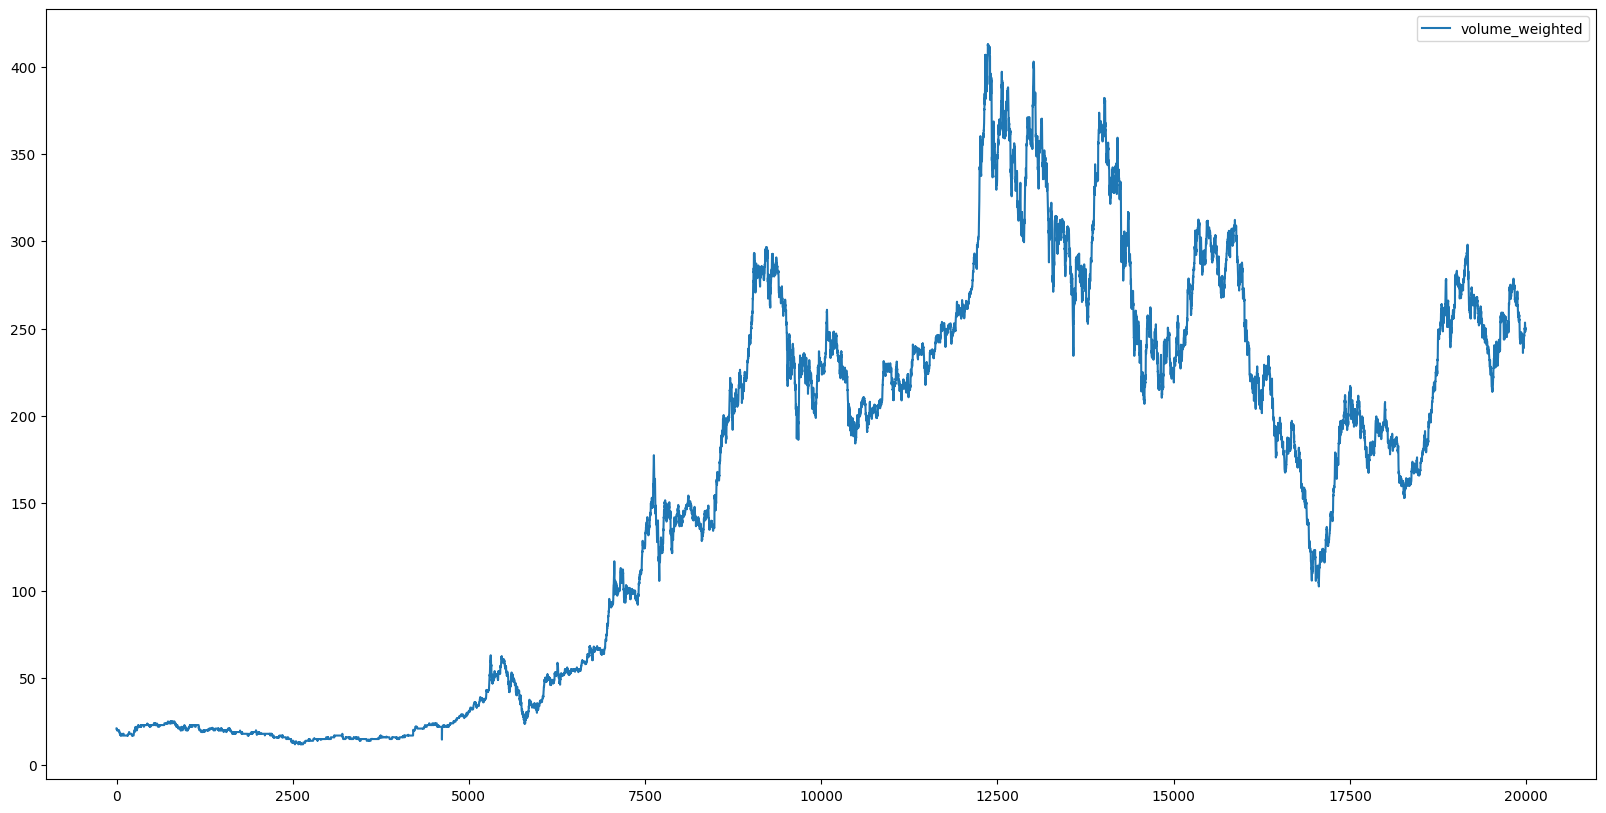

In [8]:
df_for_plot = df_for_training
df_for_plot.plot.line(figsize=(20, 10))

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()

scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
df_for_training_scaled

array([[-1.25044905],
       [-1.25044905],
       [-1.25044905],
       ...,
       [ 0.80022484],
       [ 0.80022484],
       [ 0.80022484]])

In [11]:
df_for_training.shape[1]

1

In [12]:
trainX = []
trainY = []

n_future = 1
n_past = 24*5

for i in range (n_past, len(df_for_training_scaled) - n_future + 1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print("trainX shape == {}.".format(trainX.shape))
print("trainY shape == {}.".format(trainY.shape))

trainX shape == (19875, 120, 1).
trainY shape == (19875, 1).


In [13]:
from keras.models import Sequential
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [14]:
with tf.device('/cpu:0'):
    model = Sequential()
    activation_fn = 'tanh'

    model.add(LSTM(32, activation=activation_fn, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dropout(0.3))

    model.add(LSTM(32, activation=activation_fn))
    model.add(Dropout(0.3))

    model.add(Dense(1))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')

    model.summary()

2023-10-03 07:07:45.460773: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-10-03 07:07:45.460794: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-10-03 07:07:45.460800: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-10-03 07:07:45.461065: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-03 07:07:45.461679: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120, 32)           4352      
                                                                 
 dropout (Dropout)           (None, 120, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 12705 (49.63 KB)
Trainable params: 12705 (49.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
with tf.device('/cpu:0'):
    history = model.fit(trainX, trainY, epochs=32, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/32
559/559 [==============================] - 17s 27ms/step - loss: 0.0394 - val_loss: 0.0013
Epoch 2/32
559/559 [==============================] - 15s 26ms/step - loss: 0.0188 - val_loss: 0.0015
Epoch 3/32
559/559 [==============================] - 15s 27ms/step - loss: 0.0180 - val_loss: 0.0012
Epoch 4/32
559/559 [==============================] - 15s 27ms/step - loss: 0.0180 - val_loss: 0.0015
Epoch 5/32
559/559 [==============================] - 15s 27ms/step - loss: 0.0173 - val_loss: 0.0012
Epoch 6/32
559/559 [==============================] - 15s 27ms/step - loss: 0.0174 - val_loss: 0.0014
Epoch 7/32
559/559 [==============================] - 15s 28ms/step - loss: 0.0172 - val_loss: 0.0024
Epoch 8/32
559/559 [==============================] - 15s 27ms/step - loss: 0.0171 - val_loss: 0.0012
Epoch 9/32
559/559 [==============================] - 15s 27ms/step - loss: 0.0166 - val_loss: 9.0780e-04
Epoch 10/32
559/559 [==============================] - 15s 27ms/step - loss: 0

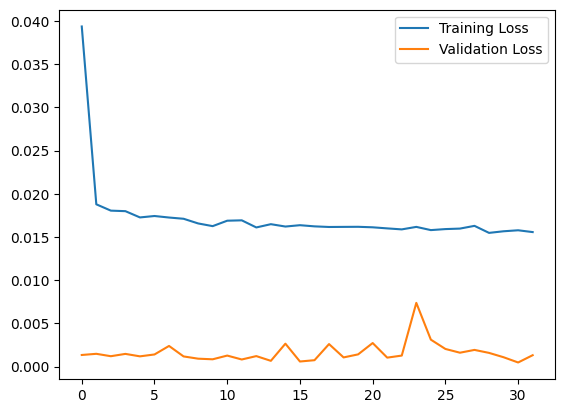

In [16]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [17]:
n_past = 1
n_for_prediction = 24*5
predict_period_dates = pd.date_range(list(train_timestamps)[-n_past], periods=n_for_prediction, freq='H').tolist()

In [18]:
with tf.device('/cpu:0'):
    prediction = model.predict(trainX[-n_for_prediction:])

In [ ]:
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)

prediction_copies.shape

(1440, 1)

In [ ]:
y_pred_future = scaler.inverse_transform(prediction_copies)[:, 0]

In [ ]:
# Function to replicate each business day to hourly intervals
def replicate_to_hourly(business_days, trading_hours_start, trading_hours_end):
    hourly_timestamps = []
    for business_day in business_days:
        for hour in range(trading_hours_start, trading_hours_end):
            new_time = pd.Timestamp(f"{business_day.date()} {hour:02d}:00:00")
            hourly_timestamps.append(new_time)
    return pd.Series(hourly_timestamps)

# Define trading hours
trading_hours_start = 9  # 9:30 a.m. rounded down
trading_hours_end = 16  # 4:00 p.m.

hourly_timestamps = replicate_to_hourly(predict_period_dates, trading_hours_start, trading_hours_end)

df_forecast = pd.DataFrame({
    'timestamp': hourly_timestamps,
    'volume_weighted': np.repeat(y_pred_future, trading_hours_end - trading_hours_start)
})

df_forecast['timestamp'] = pd.to_datetime(df_forecast['timestamp'])

<Axes: xlabel='timestamp', ylabel='volume_weighted'>

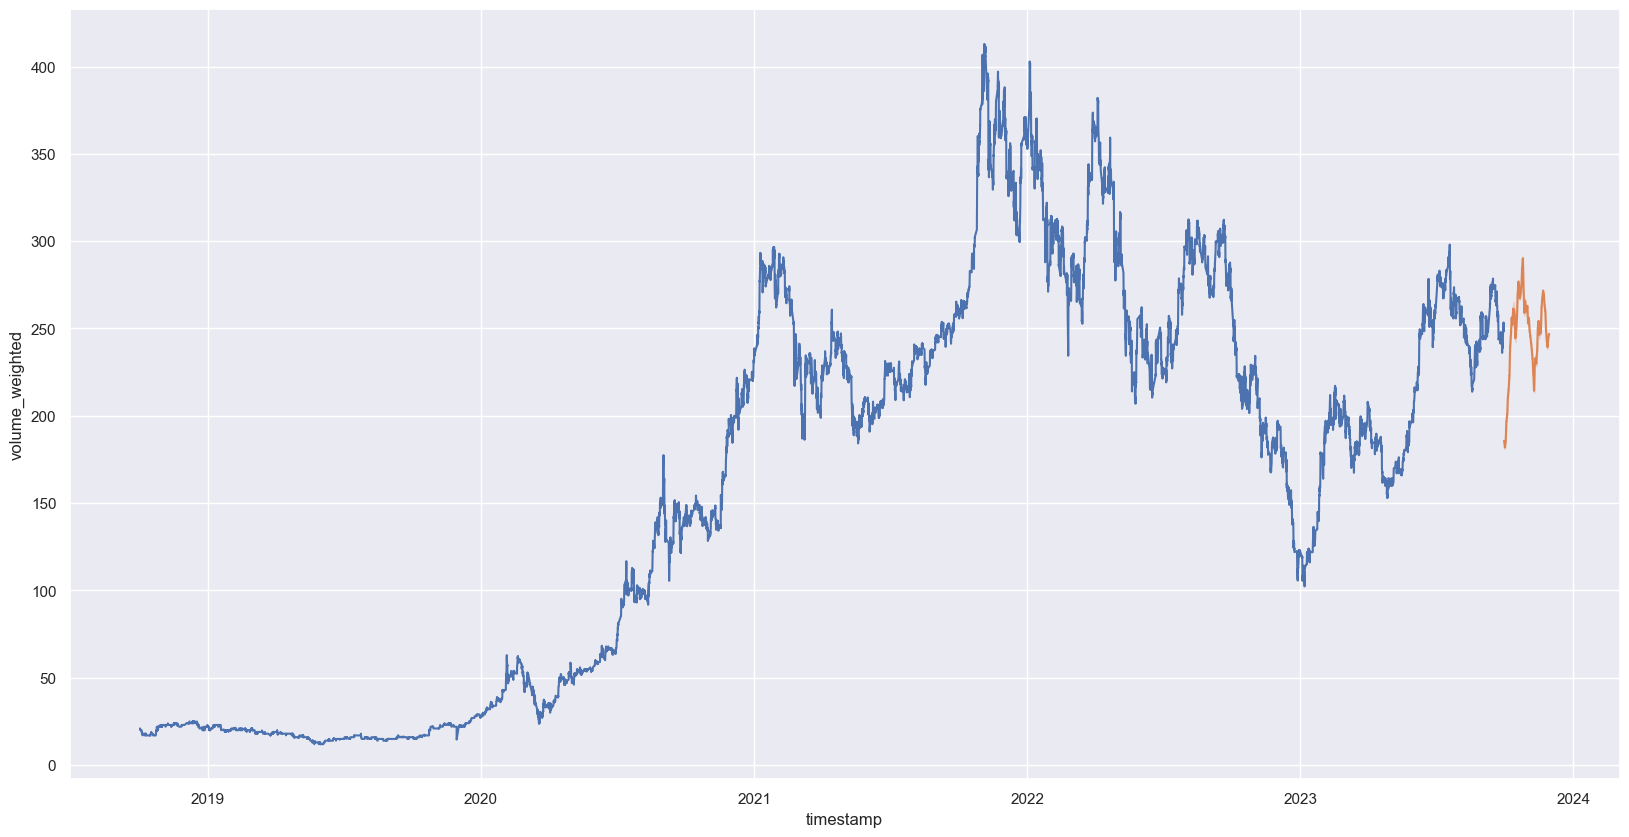

In [ ]:
original = df[['timestamp', 'volume_weighted']].copy()
original['timestamp'] = pd.to_datetime(original['timestamp'])

original = original.loc[original['timestamp'] >= '2018-10-01']

sns.set(rc={'figure.figsize':(20, 10)})
sns.lineplot(x='timestamp', y='volume_weighted', data=original)
sns.lineplot(x='timestamp', y='volume_weighted', data=df_forecast)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

# Calculate metrics
y_true = df_for_training[-n_for_prediction:]
mae = mean_absolute_error(y_true, y_pred_future)
mse = mean_squared_error(y_true, y_pred_future)
rmse = sqrt(mse)
r2 = r2_score(y_true, y_pred_future)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 2.976328621051471
Mean Squared Error: 12.146040823480886
Root Mean Squared Error: 3.4851170458796483
R-squared: 0.9789008487775439


In [ ]:
spark.stop()